In [324]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import sklearn
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score,make_scorer
from ConstructDatatset import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from TotalCalculation import *
from preprocessing import *
from ClassPrediction import *

In [325]:
df1 = Builddataset().concateDataset(folder_name = r'C:\Users\ASUS\Documents\NARIT_internship_data\CSV_dataset_old\Dataset_06_2024')
df2 = Builddataset().concateDataset(folder_name = r'C:\Users\ASUS\Documents\NARIT_internship_data\CSV_dataset_old\Dataset_12_2023')

In [326]:
date1 = []
for i in df1.index.tolist():
    date1.append(timeConvertion().ticks_to_datetime(i,time_zone=7))
df1['Time'] = date1
date2 = []
for i in df2.index.tolist():
    date2.append(timeConvertion().ticks_to_datetime(i,time_zone=7))
df2['Time'] = date2


In [327]:
df1['Time (decimal)'] = df1['Time'].dt.hour+df1['Time'].dt.minute/60
df2['Time (decimal)'] = df2['Time'].dt.hour+df2['Time'].dt.minute/60

name_y = str('Blue channel')
name_x = np.arange(len(df))
dintr = np.gradient(df['Blue channel'])
dintb = np.gradient(df['Red channel'])

plt.figure(figsize=(30,20))
sns.lineplot(data=df,x=name_x,y=df[name_y],c='blue')
sns.lineplot(data=df,x=name_x,y=df['Red channel'],c='green')
sns.lineplot(data=df,x=name_x,y=df['intensity'])
plt.plot(dintr)
plt.plot(dintb,c='r')

df

In [328]:
start_date = '2024-01-01'
end_date = str(df1['Time'].tolist()[1])
location = [18.849417,98.9538]
days = timeConvertion().time_duration(start_date,end_date,include_end_date=True).days

LSTM = SunPosition.LSTM(time_zone_offset=7)
EoT = SunPosition.calculate_EoT(day=days)
TC = SunPosition.TimeCorrectionFactor(Longitude=location[1],LSTM=LSTM,EoT=EoT)
dec = SunPosition.declination(day=days)
suntime = SunPosition.DaytimeInfo(latitude=location[0],declination=dec,TC=TC)
sunrise1,sunset1 = SunPosition.DaytimeInfo(latitude=location[0],declination=dec,TC=TC)

start_date = '2023-01-01'
end_date = str(df2['Time'].tolist()[1])
location = [18.849417,98.9538]
days = timeConvertion().time_duration(start_date,end_date,include_end_date=True).days

LSTM = SunPosition.LSTM(time_zone_offset=7)
EoT = SunPosition.calculate_EoT(day=days)
TC = SunPosition.TimeCorrectionFactor(Longitude=location[1],LSTM=LSTM,EoT=EoT)
dec = SunPosition.declination(day=days)
suntime = SunPosition.DaytimeInfo(latitude=location[0],declination=dec,TC=TC)
sunrise2,sunset2 = SunPosition.DaytimeInfo(latitude=location[0],declination=dec,TC=TC)

In [329]:

df1 = Builddataset().DayNightSplit(suntime=[sunrise1,sunset1],Mode='day',dataframe=df1)
df2 = Builddataset().DayNightSplit(suntime=[sunrise2,sunset2],Mode='day',dataframe=df2)
df = pd.concat([df1,df2])

In [330]:
df.isna().sum()

contrast          0
dissimilarity     0
homogeneity       0
energy            0
correlation       0
ASM               0
intensity         0
Red channel       0
Blue channel      0
skewness          0
std               0
different(R-B)    0
Time              0
Time (decimal)    0
dtype: int64

In [331]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
X = df.drop(columns=['Time (decimal)','Time','Red channel','Blue channel','correlation','intensity','skewness','different(R-B)'])
scaler = RobustScaler()
scaled = scaler.fit_transform(X)
#feature = PowerTransformer().get_feature_names_out(input_features=scaler.feature_names_in_)
#y = df['Label_minik']
#pca = PCA(n_components=5,svd_solver='full')
#pca.fit(scaled)
principal = scaled
principal.shape

(27941, 6)

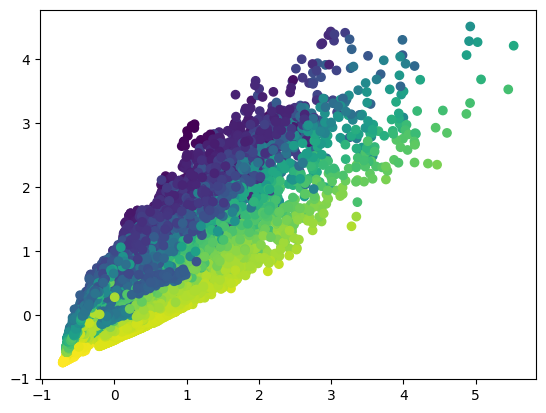

In [332]:
plt.scatter(principal[:,0],principal[:,1],c=X['homogeneity'])

In [333]:
#df = df.dropna()
#x = df.drop(columns=['Time (decimal)','Time','correlation','intensity','Red channel','Blue channel','skewness','std','different(R-B)'])
dataset = principal

#dataset = list(x.itertuples(index=False,name=None))
#dataset = np.array(dataset)

<Axes: >

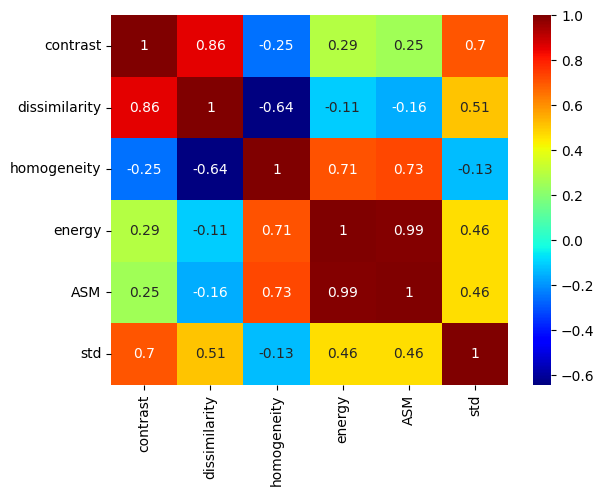

In [334]:
sns.heatmap(data=X.corr(),cmap='jet',annot=True)

In [335]:
from sklearn.metrics.pairwise import euclidean_distances
np.random.seed(42)
kmeans = KMeans(init='k-means++', n_clusters=5, n_init='auto', random_state=42, tol=1e-5,max_iter=300,algorithm='lloyd')
minik = MiniBatchKMeans(n_clusters=5,batch_size=1036, max_no_improvement=20, tol=1e-5, random_state=42, init='k-means++' ,n_init='auto', max_iter=300 ,reassignment_ratio=0.001)
#af = AffinityPropagation(damping=0.95, max_iter=500, convergence_iter=20, preference=-50, affinity='euclidean')
GMM = GaussianMixture(n_components=5, tol=1e-4, init_params='kmeans',covariance_type='full', max_iter=500, random_state=42, n_init=10)
labels = GMM.fit_predict(dataset)
labels_kmean = kmeans.fit_predict(dataset)
labels_minik = minik.fit_predict(dataset)
#labels_af = af.fit_predict(dataset)

In [336]:
df.loc[:, 'Label_minik'] = labels_minik
df.loc[:, 'Label_Kmean'] = labels_kmean

<Axes: >

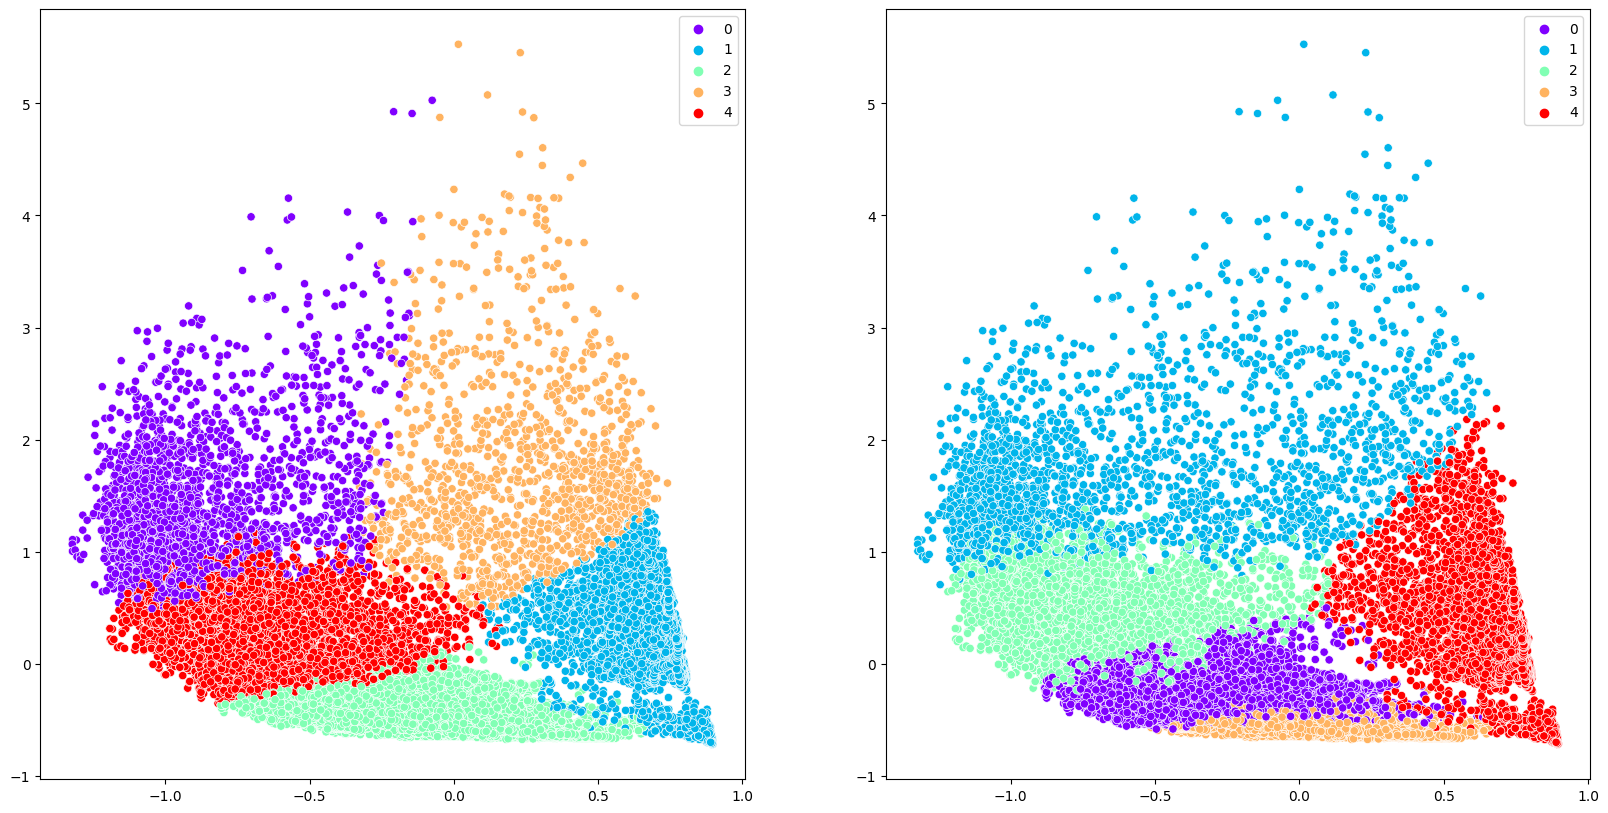

In [337]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.scatterplot(data=principal,x=principal[:,2],y=principal[:,0],hue=labels_minik,palette='rainbow')
plt.subplot(1,2,2)
sns.scatterplot(data=principal,x=principal[:,2],y=principal[:,0],hue=labels_kmean,palette='rainbow')

In [338]:
print(silhouette_score(dataset,labels_kmean))
print(silhouette_score(dataset,labels_minik))
#print(silhouette_score(dataset,labels))

0.48369660986849056
0.5482017760430923


In [354]:
num = 6
plt.figure(figsize=(30,10))
arr1 = plt.hist(principal[:,num],bins=200,log=False)
print(max(arr1[0]))
print(arr1[1][np.argmax((arr1[0]))])
print(np.mean(principal[:,num]))
print(np.median(principal[:,num]))
plt.axvline(np.mean(principal[:,num]),c='r')
plt.axvline(np.median(principal[:,num]),c='y')

IndexError: index 6 is out of bounds for axis 1 with size 6

<Figure size 3000x1000 with 0 Axes>

{'whiskers': [<matplotlib.lines.Line2D at 0x16d4783a4a0>,
 'caps': [<matplotlib.lines.Line2D at 0x16d4783a9e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x16d4783a200>],
 'medians': [<matplotlib.lines.Line2D at 0x16d4783af20>],
 'fliers': [<matplotlib.lines.Line2D at 0x16d4783b1c0>],
 'means': []}

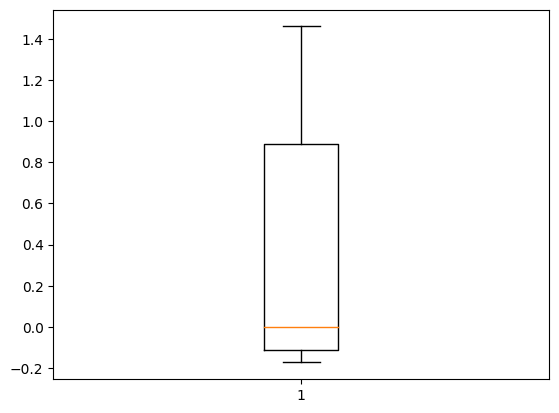

In [350]:
plt.boxplot(principal[:,3])

Text(0, 0.5, 'pc2')

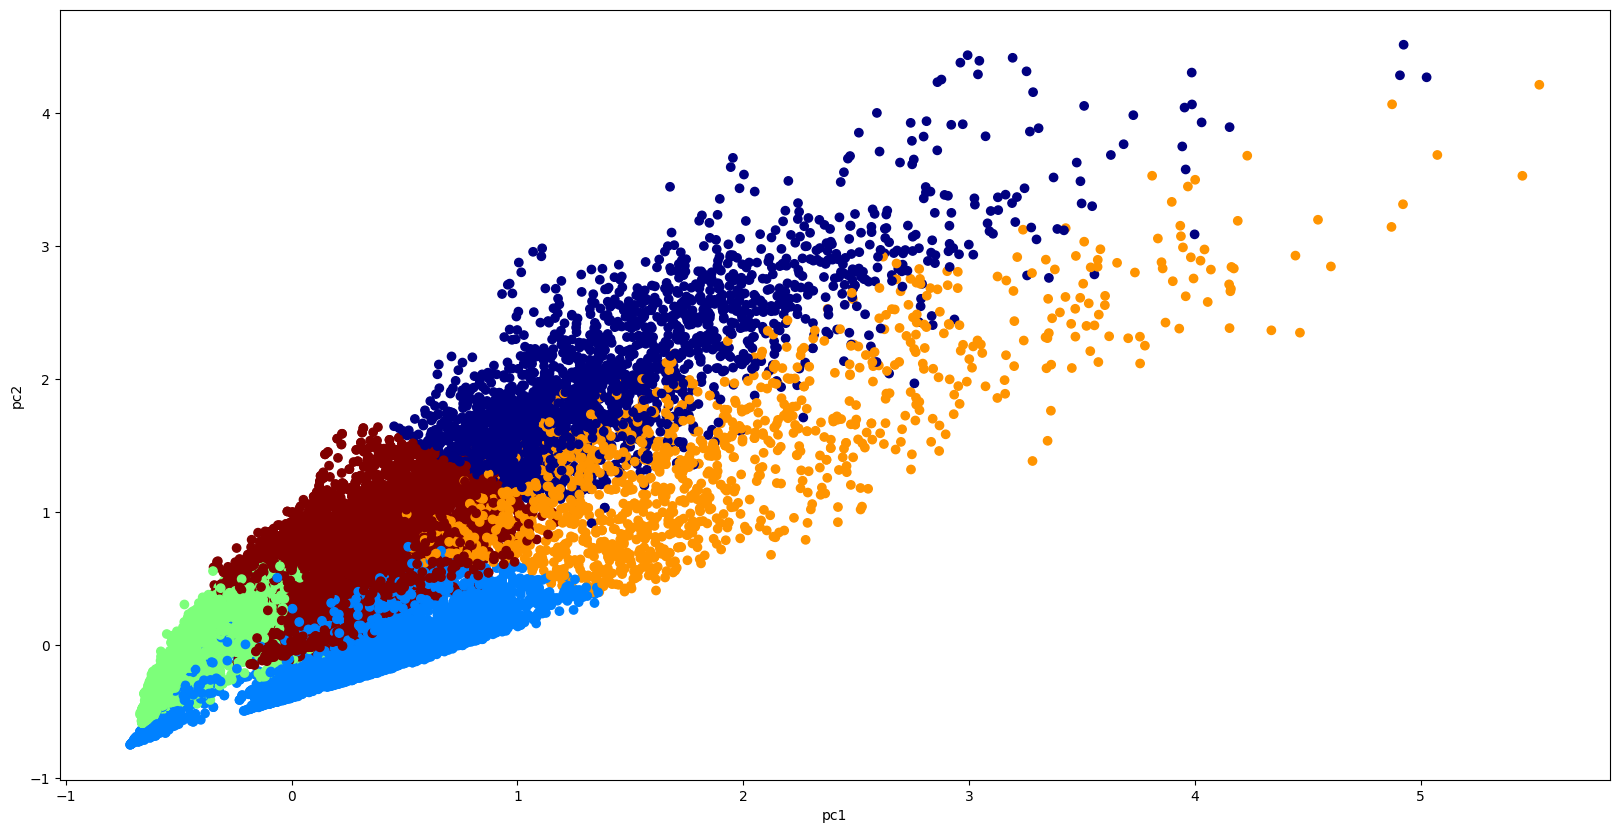

In [340]:
plt.figure(figsize=(20,10))
plt.scatter(principal[:,0],principal[:,1],c=df['Label_minik'],cmap='jet')
plt.xlabel('pc1')
plt.ylabel('pc2')

In [341]:
d

NameError: name 'd' is not defined

In [ ]:
#Supervised 
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
x = dataset
y = df['Label_Kmean']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
SVM = SVC(C=1.0,kernel='linear',tol=1e-4,cache_size=400,max_iter=-1,random_state=42)
SVM.fit(X_train,y_train)
Pred_svm = SVM.predict(X_test)

0.9864998353638459


<Axes: >

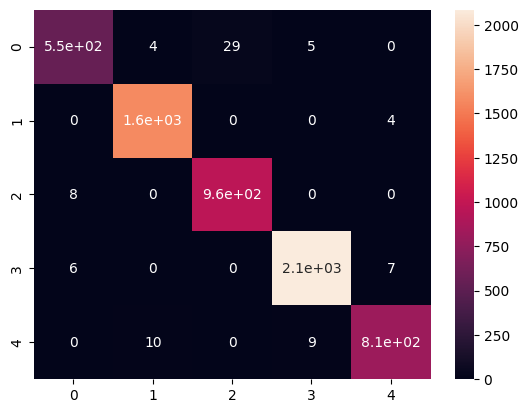

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix
print(accuracy_score(y_test,Pred_svm))
con = confusion_matrix(y_test,Pred_svm)
sns.heatmap(data=con,annot=True)

from sklearn.model_selection import GridSearchCV

def silhouette_scorer(estimator, X):
    cluster_labels = estimator.fit_predict(X)
    return silhouette_score(X, cluster_labels)
# Example adjustment for KMeans
param_grid_kmeans = {
    'tol' : [1e-4,1e-5,1e-6],
    'n_clusters': [5, 7, 9, 11],
    'init': ['k-means++', 'random'],
    'n_init': [10, 20, 'auto'],
    'max_iter': [300, 500, 700],
    'batch_size': [536,1036,1536]
}
grid_search_kmeans = GridSearchCV(MiniBatchKMeans(random_state=42), param_grid_kmeans, cv=5, scoring=silhouette_scorer)
grid_search_kmeans.fit(dataset)  # X is your data

best_kmeans = grid_search_kmeans.best_estimator_


print(best_kmeans)

In [ ]:
#print(best_kmeans)
#KMeans(n_clusters=5, n_init=20, random_state=42, tol=1e-05) : sobel
#KMeans(init='k-means++', n_clusters=5, n_init=20, random_state=42, tol=1e-05,algorithm='lloyd')

#MiniBatchKMeans(max_iter=300, n_clusters=5, n_init=10, random_state=42,tol=0.0001) : sobel
#MiniBatchKMeans(n_clusters=5,batch_size=1500, max_no_improvement=30, tol=1e-4, random_state=42, init='k-means++' ,n_init=10, max_iter=500 ,reassignment_ratio=0.001)
#--normal glcm---
#MiniBatchKMeans(batch_size=500, max_iter=300, n_clusters=5, n_init=20,random_state=42, tol=1e-05) \\ same
#KMeans(n_clusters=5, n_init='auto', random_state=42)
#---------New dataset--------#
#KMeans(n_clusters=5, n_init='auto', random_state=42)
#MiniBatchKMeans(batch_size=1036, max_iter=300, n_clusters=5, n_init=20,random_state=42, tol=0.0001)
#KMeans(algorithm='elkan', n_clusters=5, n_init=10, random_state=42)
#MiniBatchKMeans(batch_size=1036, max_iter=300, n_clusters=5, n_init=10,random_state=42, tol=1e-06)

import pickle 

with open('af_model_1.pkl','wb') as f:
    pickle.dump(af,f)

import pickle
with open('gmm_model_Nonesobel_match.pkl', 'wb') as f:
    pickle.dump(GMM, f)
with open('kmean_model_Nonesobel_match.pkl', 'wb') as f:
    pickle.dump(kmeans, f)
with open('miniBkmean_model_Nonesobel_match.pkl', 'wb') as f:
    pickle.dump(minik, f)

from preprocessing import image
image_list = image.getFilename(r'C:\Users\ASUS\Documents\NARIT_internship_data\Test_folder')

filetime = []
for file in image_list:
    filetime.append(int(os.path.splitext(os.path.basename(file))[0]))


viz = visualizer()
number = 1
source_folder = r'All_sky_camera_Astropark_Chaingmai\2024-06\2024-06-12'
destination_folder = r'C:\Users\ASUS\Documents\NARIT_internship_2024\Tester'

viz.copy_matching_files(df=viz.match_label(df=df,number=number), source_folder=source_folder, destination_folder=destination_folder)

pred = prediction()
path = r'All_sky_camera_Astropark_Chaingmai\2024-06\2024-06-09\638534868144584540.png'
pred_1,pred_2,cloud_percentage,sky_status,final = pred.total_prediction(image_path=path,mask_path='mask_delete_5.png',crop_size=570,kmeans=kmeans,GMM=GMM,df=df)

mask = cv2.imread('mask_delete_5.png',cv2.IMREAD_GRAYSCALE)
mask = crop_center(img=mask,crop_size=570)
img,name = load_single_image(path=path,crop_size=570,mask=mask,apply_crop_sun=False)
image,value,RB = pred.RBsingle(input=img,dataframe=df)
cloud_ratio = pred.CloudRatio(image=img,mask=mask)

import requests
import cv2
import numpy as np
import hashlib
import time

def get_image_hash(image_data):
    return hashlib.md5(image_data).hexdigest()

image_url = "http://weather.narit.or.th/images/allskyimage/ASTROPARK/2024-08-19"
previous_hash = None

while True:
    # Fetch the image from the web
    response = requests.get(image_url)
    if response.status_code == 200:
        # Get the current hash of the image
        current_hash = get_image_hash(response.content)
        
        # Compare with the previous hash
        if current_hash != previous_hash:
            # The image has changed
            print("Image has changed, updating display...")
            image_array = np.frombuffer(response.content, np.uint8)
            image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
            cv2.imshow('Auto-Updated Image', image)
            
            # Update the previous hash
            previous_hash = current_hash
            
            # Wait for 1 second to avoid rapid flickering
            if cv2.waitKey(1000) & 0xFF == ord('q'):
                break
        else:
            print("No change detected.")
    
    # Check every 10 seconds for a change
    time.sleep(10)
    cv2.destroyAllWindows()


sns.scatterplot(data=df,x=df['contrast'],y=df['homogeneity'],hue=labels_kmean)

sns.heatmap(df.corr(),annot=True)